# Face recognition

Juan Camilo Azuero

## Introduction

This notebook is part of the final project of the course Introduction to Deep Learning from the University of Colorado Boulder. The goal of the project is to create a face recognition application that is capable of recognizing someone based on a couple of pictures. There are many models deployed with such capabilities powering applications like the face id unlock feature some cellphones have.   

## Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from matplotlib.image import imread

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
FACES_DIR = "/../Data/Faces"
FACES_CSV = "/../Data/faces_dir.csv"

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

This project is based on the Kaggle dataset <a href="https://www.kaggle.com/datasets/quadeer15sh/lfw-facial-recognition">LFW - Facial Recognition</a> that contains around 13,233 labelled pictures of 5,749 distinct famous people. The pictures are stored in .jpg format and all of them have a size of (250, 250, 3) including the RGB channels. This dataset has high bias and should not be used for any commercial purpose as stated in Kaggle, but it will serve to create a demo of the face pairing model. 

First, let's create a pandas dataframe with information about the diferent pictures in the dataset.

In [4]:
CWD = os.getcwd()

<IPython.core.display.Javascript object>

In [5]:
def create_faces_dir(faces_url: str, faces_csv: str):
    """Creates dir of labelled images of faces"""
    faces = os.listdir(CWD + faces_url)
    faces_df = pd.DataFrame(columns=["address"], data=faces)
    faces_df["number"] = faces_df["address"].apply(
        lambda x: int(x.split("_")[-1].split(".")[0])
    )
    faces_df["name"] = faces_df["address"].apply(lambda x: " ".join(x.split("_")[:-1]))
    faces_df.to_csv(CWD + faces_csv)

<IPython.core.display.Javascript object>

In [6]:
# create_faces_dir(FACES_DIR, FACES_CSV)

<IPython.core.display.Javascript object>

In [7]:
faces_df = pd.read_csv(CWD + FACES_CSV, index_col=0)

<IPython.core.display.Javascript object>

This dataframe contains information about the address of the picture, the numbber of pictures available for that person, and his name. 

In [8]:
faces_df.head()

,address,number,name
0,Kevin_Gil_0001.jpg,1,Kevin Gil
1,Gerry_Kelly_0001.jpg,1,Gerry Kelly
2,Eliane_Karp_0003.jpg,3,Eliane Karp
3,Vojislav_Kostunica_0006.jpg,6,Vojislav Kostunica
4,Phil_Johnson_0001.jpg,1,Phil Johnson


<IPython.core.display.Javascript object>

In [9]:
num_unique = len(faces_df["name"].unique())
print(
    f"There are {len(faces_df)} pictures and {num_unique} distinct persons in the dataset"
)

There are 13233 pictures and 5749 distinct persons in the dataset


<IPython.core.display.Javascript object>

The number of pictures for the 20 people with more images ranges between 530 for George Bush, and 39 for Hans Blix.

In [10]:
picture_counts = faces_df["name"].value_counts()
picture_counts.head(20)

George W Bush                530
Colin Powell                 236
Tony Blair                   144
Donald Rumsfeld              121
Gerhard Schroeder            109
Ariel Sharon                  77
Hugo Chavez                   71
Junichiro Koizumi             60
Jean Chretien                 55
John Ashcroft                 53
Jacques Chirac                52
Serena Williams               52
Vladimir Putin                49
Luiz Inacio Lula da Silva     48
Gloria Macapagal Arroyo       44
Arnold Schwarzenegger         42
Jennifer Capriati             42
Laura Bush                    41
Lleyton Hewitt                41
Hans Blix                     39
Name: name, dtype: int64

<IPython.core.display.Javascript object>

In contrast, more than 2/3 of the notable people in this dataset only have one picture available.

(0.0, 50.0)

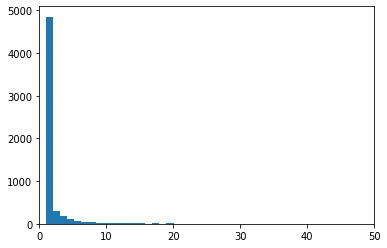

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots()
ax.hist(picture_counts.values, bins=500)
ax.set_xlim(0, 50)

In [12]:
print(
    f"""There are {len(faces_df)} pictures and {num_unique} distinct persons in the dataset.
Only {num_unique-(picture_counts == 1).sum()} have more than 1 picture"""
)

There are 13233 pictures and 5749 distinct persons in the dataset.
Only 1680 have more than 1 picture


<IPython.core.display.Javascript object>

This dataset is very far from being a good representation of the diversity in the world and has a strong bias. For further iterations of the model another dataset should be contructed according to the application requirements and ethical implications. More information about the *Labeled Faces in the Wild* dataset can be found in this <a href="http://vis-www.cs.umass.edu/lfw/#reference">reference</a> from the University of Massachusetts Amherst.

Concluding the disclaimer, let's split the pictures into train, validation and test sets. The train set is includes 60% of the 5749 different notables, while the validation and test set will contain 20% each. 

In [13]:
training_set = set(
    np.random.choice(
        faces_df["name"].unique(), size=int(num_unique * 0.6), replace=False
    )
)

<IPython.core.display.Javascript object>

In [14]:
cv_set = set(
    np.random.choice(
        list(set(faces_df["name"].unique()) - training_set),
        size=int(num_unique * 0.2),
        replace=False,
    )
)

<IPython.core.display.Javascript object>

In [15]:
test_set = (set(faces_df["name"].unique()) - training_set) - cv_set

<IPython.core.display.Javascript object>

In [16]:
faces_df_train = faces_df[faces_df["name"].isin(training_set)]
faces_df_cv = faces_df[faces_df["name"].isin(cv_set)]
faces_df_test = faces_df[faces_df["name"].isin(test_set)]

<IPython.core.display.Javascript object>

## ETL 

The proposed model for the task is a CNN with an input of two images and a single binary output that indicate if the two images come from the same person. In order to optimize the training both inputs go through the same feature extraction submodel, and then the outputs are concatenated and input a dense neural network that classify the images.

![picture](../Images/CNN_diagram.png)

For the construction of this model Keras will be used in top of the tensorflow backend. Thus, in order to train a NN we need to create a tensorflow dataset object. The next cell creates a generator that produces with probability 1/2 a pair of pictures from the same person and with probability 1/2 pictures from different people. The image pair generator concatenates both images into a unique np array and does a horizantal random flip of the image for data augmentation.

In [17]:
class ImagePairDataset:
    def __init__(
        self, 
        df,
        size=10000,
        prop_same=0.5
    ):
        # df with addresses of the images
        self.df = df
        # Simulated size of dataset (ITS RANDOM GENERATION)
        self.size = size
        # Proportion of picture pairs from 1 person
        self.prop_same = prop_same
        
        val_counts = df["name"].value_counts()
        self.val_counts_rep = val_counts[val_counts > 1]

    def __len__(self):
        return self.size

    def __getitem__(self,idx):
        same = None
        sample_inds=None
        if np.random.rand() < self.prop_same:
            # Generation of pictures from same person
            person_to_sample = self.val_counts_rep[
                self.val_counts_rep.cumsum() > np.random.randint((self.val_counts_rep).sum())
            ].index[0]
            sample_inds = np.random.choice(
                self.df[self.df["name"] == person_to_sample]["address"].values, 2,
            )
            same = 1
        else:
            # Generation of pictures from different people
            sample_inds = np.random.choice(self.df.index, 2)
            while self.df.loc[sample_inds[0], "name"] == self.df.loc[sample_inds[1], "name"]:
                sample_inds = np.random.choice(self.df.index, 2)
            sample_inds = tuple(self.df.loc[sample_inds,'address'])
            same = 0
        im_1 = self.randomflip(imread(CWD + FACES_DIR + "/" + sample_inds[0]) / 127.5 - 1)
        im_2 = self.randomflip(imread(CWD + FACES_DIR + "/" + sample_inds[1]) / 127.5 - 1)
        
        return(
            np.concatenate([im_1,im_2]),
            same,
        )
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
    def randomflip(self, arr):
        if np.random.rand() > 0.5:
            return arr[:, np.arange(arr.shape[1] - 1, -1, -1), :]
        return arr


<IPython.core.display.Javascript object>

In [18]:
image_pair_generator_train = ImagePairDataset(faces_df_train, size=100000)
image_pair_generator_cv = ImagePairDataset(faces_df_cv, size=10000)
image_pair_generator_test = ImagePairDataset(faces_df_test, size=100000)

<IPython.core.display.Javascript object>

Now let's create the tensorflow datasets. A batch size of 400 was selected after experimentation with the available hardware.

In [19]:
ot = (tf.float32, tf.int64)
os = (
    tf.TensorShape([500, 250, 3]),
    tf.TensorShape([]),
)
batch_size = 400
train_ds = tf.data.Dataset.from_generator(
    image_pair_generator_train, output_types=ot, output_shapes=os
).batch(batch_size)
cv_ds = tf.data.Dataset.from_generator(
    image_pair_generator_cv, output_types=ot, output_shapes=os
).batch(batch_size)
test_ds = tf.data.Dataset.from_generator(
    image_pair_generator_test, output_types=ot, output_shapes=os
).batch(batch_size)

Metal device set to: Apple M1 Max


2022-08-05 22:29:51.289908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-05 22:29:51.290274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<IPython.core.display.Javascript object>

Let's visualize the dataset and make sure that everything is working

2022-08-05 22:29:51.750651: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


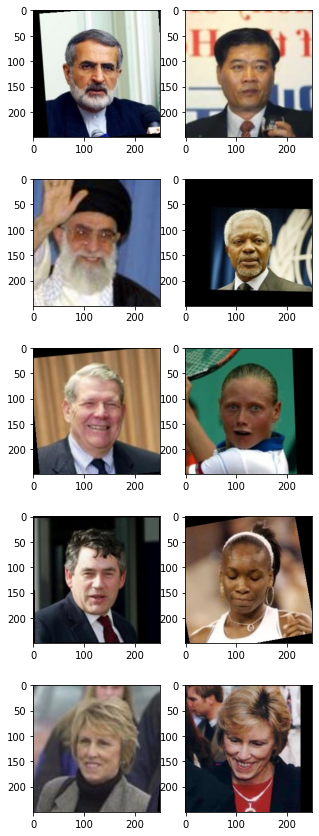

<IPython.core.display.Javascript object>

In [20]:
for imgs, labels in train_ds:
    break
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(5, 15)
for i in range(5):
    im_1 = (imgs[i].numpy()[:250] + 1) / 2
    im_2 = (imgs[i].numpy()[250:] + 1) / 2
    axs[i, 0].imshow(im_1)
    axs[i, 1].imshow(im_2)

## Modelling

### Feature extractor

For the feature extractor a CNN with around 1 million parameters. This CNN is formed by 4 convolutional blocks that include a batch normalization layer, followed by a convolutional layer with relu activation function, a dropout layer and a max pooling layer. The architechture detail exposed below is the result of iteration and refinement of the CNN. The strategy followed was to first to look for an architechture big enough to fit (or overfit) the training data, and then regularize such architechture by using the dropout layers.

In [21]:
inputs = keras.layers.Input([250, 250, 3], dtype=tf.float32)
# B1
x = keras.layers.BatchNormalization()(inputs)
x = keras.layers.Conv2D(20, 5, strides=(2, 2), activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
# B2
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(50, 3, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
# B3
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(100, 3, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
# B4
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(150, 3, strides=(3, 3), activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Conv2D(400, 4, strides=(4, 4), activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)
features_extracted = keras.layers.Flatten()(x)
feature_extraction_model = keras.Model(inputs, features_extracted)

<IPython.core.display.Javascript object>

In [22]:
feature_extraction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 123, 123, 20)      1520      
                                                                 
 dropout (Dropout)           (None, 123, 123, 20)      0         
                                                                 
 average_pooling2d (AverageP  (None, 61, 61, 20)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 20)       80    

<IPython.core.display.Javascript object>

### Face pair model

The model is now assembled into a final model by includes 2 dense hidden layer and an output layer over the concatenation of the feature extracted from both inputs.

In [23]:
inputs = keras.layers.Input([500, 250, 3], dtype=tf.float32)
input_x, input_y = tf.split(
    inputs,
    num_or_size_splits=2,
    axis=1,
)
features_x = feature_extraction_model(input_x)
features_y = feature_extraction_model(input_y)
concat_feat = keras.layers.concatenate([features_x, features_y])
dense = keras.layers.Dense(100, activation="relu")(concat_feat)
dense = keras.layers.Dropout(0.3)(dense)
dense = keras.layers.Dense(50, activation="relu")(dense)
dense = keras.layers.Dropout(0.1)(dense)
output = keras.layers.Dense(1, activation="sigmoid")(dense)
model = keras.Model(inputs=inputs, outputs=output)

<IPython.core.display.Javascript object>

The model is compiled using the binary crossentropy loss and the adam optimizer. 

In [24]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "AUC"],
)

<IPython.core.display.Javascript object>

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.split (TFOpLambda)          [(None, 250, 250, 3  0           ['input_2[0][0]']                
                                ),                                                                
                                 (None, 250, 250, 3                                               
                                )]                                                                
                                                                                            

<IPython.core.display.Javascript object>

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

<IPython.core.display.Javascript object>

In [27]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "../data/model_face_pair_2", save_best_only=True, monitor="val_loss", verbose=False
)

<IPython.core.display.Javascript object>

In [ ]:
fit_history = model.fit(
    x=train_ds,
    epochs=150,
    validation_data=cv_ds,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/150


2022-08-05 22:29:56.561033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    250/Unknown - 527s 2s/step - loss: 0.6981 - accuracy: 0.5095 - auc: 0.5149

2022-08-05 22:38:43.460371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 565s 2s/step - loss: 0.6981 - accuracy: 0.5095 - auc: 0.5149 - val_loss: 0.6869 - val_accuracy: 0.5579 - val_auc: 0.5801
Epoch 2/150
250/250 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.5903 - auc: 0.6286

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 564s 2s/step - loss: 0.6659 - accuracy: 0.5903 - auc: 0.6286 - val_loss: 0.5818 - val_accuracy: 0.6879 - val_auc: 0.7624
Epoch 3/150
250/250 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7176 - auc: 0.7876

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 581s 2s/step - loss: 0.5559 - accuracy: 0.7176 - auc: 0.7876 - val_loss: 0.5358 - val_accuracy: 0.7231 - val_auc: 0.8126
Epoch 4/150
250/250 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.7502 - auc: 0.8292

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 568s 2s/step - loss: 0.5066 - accuracy: 0.7502 - auc: 0.8292 - val_loss: 0.5000 - val_accuracy: 0.7619 - val_auc: 0.8445
Epoch 5/150
250/250 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.7771 - auc: 0.8574

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 562s 2s/step - loss: 0.4674 - accuracy: 0.7771 - auc: 0.8574 - val_loss: 0.4841 - val_accuracy: 0.7585 - val_auc: 0.8580
Epoch 6/150
250/250 [==============================] - ETA: 0s - loss: 0.4416 - accuracy: 0.7933 - auc: 0.8732

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 564s 2s/step - loss: 0.4416 - accuracy: 0.7933 - auc: 0.8732 - val_loss: 0.4580 - val_accuracy: 0.7832 - val_auc: 0.8630
Epoch 7/150
250/250 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.8113 - auc: 0.8899

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 562s 2s/step - loss: 0.4136 - accuracy: 0.8113 - auc: 0.8899 - val_loss: 0.4499 - val_accuracy: 0.7900 - val_auc: 0.8734
Epoch 8/150
250/250 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8248 - auc: 0.9012

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 563s 2s/step - loss: 0.3920 - accuracy: 0.8248 - auc: 0.9012 - val_loss: 0.4241 - val_accuracy: 0.8018 - val_auc: 0.8870
Epoch 9/150
250/250 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8323 - auc: 0.9070

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 562s 2s/step - loss: 0.3794 - accuracy: 0.8323 - auc: 0.9070 - val_loss: 0.4088 - val_accuracy: 0.8200 - val_auc: 0.8994
Epoch 10/150
250/250 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8402 - auc: 0.9145

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 562s 2s/step - loss: 0.3638 - accuracy: 0.8402 - auc: 0.9145 - val_loss: 0.4084 - val_accuracy: 0.8116 - val_auc: 0.8998
Epoch 11/150
250/250 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8478 - auc: 0.9215

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 563s 2s/step - loss: 0.3475 - accuracy: 0.8478 - auc: 0.9215 - val_loss: 0.3998 - val_accuracy: 0.8127 - val_auc: 0.8986
Epoch 12/150
250/250 [==============================] - 557s 2s/step - loss: 0.3384 - accuracy: 0.8530 - auc: 0.9254 - val_loss: 0.4033 - val_accuracy: 0.8185 - val_auc: 0.9014
Epoch 13/150
250/250 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8588 - auc: 0.9306

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 562s 2s/step - loss: 0.3262 - accuracy: 0.8588 - auc: 0.9306 - val_loss: 0.3874 - val_accuracy: 0.8240 - val_auc: 0.9084
Epoch 14/150
250/250 [==============================] - 560s 2s/step - loss: 0.3180 - accuracy: 0.8627 - auc: 0.9341 - val_loss: 0.3942 - val_accuracy: 0.8281 - val_auc: 0.9109
Epoch 15/150
250/250 [==============================] - 557s 2s/step - loss: 0.3032 - accuracy: 0.8712 - auc: 0.9398 - val_loss: 0.3904 - val_accuracy: 0.8256 - val_auc: 0.9127
Epoch 16/150
250/250 [==============================] - 556s 2s/step - loss: 0.2981 - accuracy: 0.8738 - auc: 0.9417 - val_loss: 0.3988 - val_accuracy: 0.8246 - val_auc: 0.9103
Epoch 17/150
250/250 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8762 - auc: 0.9438

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 560s 2s/step - loss: 0.2922 - accuracy: 0.8762 - auc: 0.9438 - val_loss: 0.3724 - val_accuracy: 0.8406 - val_auc: 0.9189
Epoch 18/150
250/250 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.8799 - auc: 0.9459

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 560s 2s/step - loss: 0.2864 - accuracy: 0.8799 - auc: 0.9459 - val_loss: 0.3584 - val_accuracy: 0.8405 - val_auc: 0.9224
Epoch 19/150
250/250 [==============================] - 555s 2s/step - loss: 0.2804 - accuracy: 0.8835 - auc: 0.9479 - val_loss: 0.3772 - val_accuracy: 0.8395 - val_auc: 0.9185
Epoch 20/150
250/250 [==============================] - 557s 2s/step - loss: 0.2734 - accuracy: 0.8856 - auc: 0.9505 - val_loss: 0.3787 - val_accuracy: 0.8421 - val_auc: 0.9213
Epoch 21/150
250/250 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8889 - auc: 0.9519

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 559s 2s/step - loss: 0.2686 - accuracy: 0.8889 - auc: 0.9519 - val_loss: 0.3583 - val_accuracy: 0.8493 - val_auc: 0.9282
Epoch 22/150
250/250 [==============================] - 556s 2s/step - loss: 0.2628 - accuracy: 0.8908 - auc: 0.9543 - val_loss: 0.3645 - val_accuracy: 0.8424 - val_auc: 0.9220
Epoch 23/150
250/250 [==============================] - 556s 2s/step - loss: 0.2590 - accuracy: 0.8928 - auc: 0.9550 - val_loss: 0.3888 - val_accuracy: 0.8372 - val_auc: 0.9197
Epoch 24/150
250/250 [==============================] - 557s 2s/step - loss: 0.2549 - accuracy: 0.8946 - auc: 0.9566 - val_loss: 0.3744 - val_accuracy: 0.8469 - val_auc: 0.9265
Epoch 25/150
250/250 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.8983 - auc: 0.9587

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 558s 2s/step - loss: 0.2475 - accuracy: 0.8983 - auc: 0.9587 - val_loss: 0.3566 - val_accuracy: 0.8538 - val_auc: 0.9286
Epoch 26/150
250/250 [==============================] - 558s 2s/step - loss: 0.2489 - accuracy: 0.8986 - auc: 0.9579 - val_loss: 0.3657 - val_accuracy: 0.8504 - val_auc: 0.9292
Epoch 27/150
250/250 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.8991 - auc: 0.9592

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 558s 2s/step - loss: 0.2466 - accuracy: 0.8991 - auc: 0.9592 - val_loss: 0.3544 - val_accuracy: 0.8449 - val_auc: 0.9262
Epoch 28/150
250/250 [==============================] - 557s 2s/step - loss: 0.2409 - accuracy: 0.9020 - auc: 0.9607 - val_loss: 0.3730 - val_accuracy: 0.8426 - val_auc: 0.9286
Epoch 29/150
250/250 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9050 - auc: 0.9625

INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


INFO:tensorflow:Assets written to: ../data/model_face_pair_2/assets


250/250 [==============================] - 559s 2s/step - loss: 0.2345 - accuracy: 0.9050 - auc: 0.9625 - val_loss: 0.3540 - val_accuracy: 0.8553 - val_auc: 0.9304
Epoch 30/150
250/250 [==============================] - 559s 2s/step - loss: 0.2340 - accuracy: 0.9059 - auc: 0.9627 - val_loss: 0.3588 - val_accuracy: 0.8523 - val_auc: 0.9296
Epoch 31/150
250/250 [==============================] - 559s 2s/step - loss: 0.2319 - accuracy: 0.9056 - auc: 0.9633 - val_loss: 0.3838 - val_accuracy: 0.8472 - val_auc: 0.9275
Epoch 32/150
250/250 [==============================] - 561s 2s/step - loss: 0.2272 - accuracy: 0.9077 - auc: 0.9648 - val_loss: 0.3668 - val_accuracy: 0.8452 - val_auc: 0.9300
Epoch 33/150
250/250 [==============================] - 560s 2s/step - loss: 0.2255 - accuracy: 0.9094 - auc: 0.9653 - val_loss: 0.3678 - val_accuracy: 0.8537 - val_auc: 0.9296
Epoch 34/150
 30/250 [==>...........................] - ETA: 25:45:35 - loss: 0.2190 - accuracy: 0.9108 - auc: 0.9664

In [ ]:
plt.plot(fit_history.history["auc"])
plt.plot(fit_history.history["val_auc"])

In [ ]:
plt.plot(fit_history.history["accuracy"])
plt.plot(fit_history.history["val_accuracy"])